# Mixture Density Networks in pure `keras`

In [1]:
# Jan 12, 2020 Sun
# Tan Nian Wei
# tannianwei@aggienetwork.com

I have been studying Mixture Density Networks recently, based on fantastic resources from the following in-depth articles:
+ http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/
+ http://cbonnett.github.io/MDN.html
+ http://cbonnett.github.io/MDN_EDWARD_KERAS_TF.html
+ https://www.katnoria.com/mdn/

Given thre great work done by these authors above, we're not going into detail on MDNs here. Just to summarize, MDNs are literally mixture models expressed in neural network form. Instead of outputting point estimates for an expected outcome, MDNs output a probabilistically weighted combination of most likely probability distributions. The estimated values are then sampled from this mixture of distributions. 

MDN implementations I've seen online thus far rely on `pytorch` or `tensorflow`. I thought it would be interesting to explore implementing MDNs in pure `keras` without requiring `import tensorflow as tf` at some point. And also document my thoughts along the way.

Note: If you just want to use MDNs, https://github.com/cpmpercussion/keras-mdn-layer provides an MDN layer for `keras`.

## Data

Generate and visualize data for this demonstration:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# def sample_fun(x):
#     return 7 * np.sin(0.75*x) + 0.5*x +\
#     np.random.normal(loc=0, scale=1, size=np.squeeze(x).shape)

# ys = np.linspace(-10, 10, num=2000)
# xs = np.apply_along_axis(sample_fun, axis=0, arr=ys)

# with open('xs.npy', 'wb') as f:
#     np.save(f, xs)
    
# with open('ys.npy', 'wb') as f:
#     np.save(f, ys)

In [4]:
with open('xs.npy', 'rb') as f:
    xs = np.load(f)
    
with open('ys.npy', 'rb') as f:
    ys = np.load(f)    

We'll split the data into a training set and a testing set.

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2)

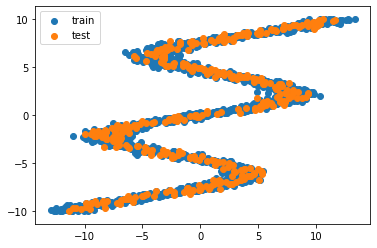

In [7]:
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.legend()
plt.show()

We will be using `xs` to predict `ys`. Note that they have a one-to-many relationship; most of `xs` maps to more than one value of `ys`. Vanilla machine learning models would be stumped, as this is the equivalent of providing a classifier with mislabelled data. Mixture models however, including MDNs, see every observation as a combination of multiple distributions. At the risk of oversimplifying, they have the wiggle room to store conflicting information in separate learned distributions.

## Model Architecture

In [8]:
from keras.layers import Input, Lambda, Concatenate, Dense
from keras.models import Model
import keras.backend as K

Using TensorFlow backend.


We are using the functional API here as it makes things easier. 

In [9]:
# This part is the same between MDNs and vanilla neural networks
nn_input = Input(shape=(1, ))
x = Dense(20, use_bias=True, activation='tanh')(nn_input)

For ease of demonstration, we'll only use a single hidden layer. We will code the architecture to use a mixture of `k` = 5 Gaussians. Each Gaussian requires three outputs: mixture probability, and mean + standard deviation to fully describe the distribution.

The output of the hidden layer is passed to 3 diverging branches in the MDN, all `Dense` layers. 
+ `pi`: mixture probability, softmax activation
+ `mu`: distribution mean, linear activation
+ `sigma`: natural log of distribution standard deviation, linear activation

In [10]:
# But here is where it diverges! 
n_mixtures = 5 # We choose to have 5 mixtures

In [11]:
pi = Dense(n_mixtures, activation='softmax')(x)
mu = Dense(n_mixtures, activation='linear')(x)
sigma = Dense(n_mixtures, activation='linear')(x)
sigma = Lambda(lambda x:K.exp(x))(sigma)

Things to note:
+ Mixture probability is configured to have softmax activation, as the sum of all mixture probabilities need to sum to one. Using softmax is a simple way to do it, but definitely not the only way.
+ log of std dev is used, as std dev is strictly a positive number. This setup guarantees std dev > 0 by adding an exponentiation step after. Again this is probably not the only way to satisfy this constraint.

In [12]:
# Finishing the network architecture
# This layer is needed else keras won't let us run!
output = Concatenate()([pi, mu, sigma])

mdn = Model(inputs=[nn_input], 
            outputs=[output])
            # outputs=[out_pi, out_mu, out_sigma])

We cap off the network with a `Concatenate` layer, so that the shape of the output layer is the same as of the data we will pass to `model.fit()`. If you are using `pytorch` or `tensorflow`, this step is not required since it is possible to implement a loss function using these distribution output layers directly. However, `keras` adheres to a `model.fit(X, y)` paradigm, and has checks in place to ensure the network is properly set up to take `X` and `y`. Thus a bit more work is needed.

Speaking of the loss function.

## Loss function

We know our model is well-trained when the likelihood of our distributions on the data is high. People have discovered that taking the log is easier to work with, and is monotonic i.e. gives similar information as the original for gradient descent purposes. Therefore our loss function will be the log-likelihood function.

PSA: Likelihood is not the same thing as probability. In very simple terms, we estimate the **probability** of outcomes when the probability distribution is known. When we flip things around and want to estimate our probability distribution given sampled data, we estimate the **likelihood** of our probability distribution when the sampled data is given.

As part of calculating log-likelihood, we need to implement a function to calculate the probability density function of a Gaussian first. We are not using `scipy.stats.norm` because that's for ONE distribution when we want to be able to calculate pdf's in batch.

In [13]:
def gaussian_pdf(y, mu, sigma):
    # Output should be in the shape of (n_mixtures, )
    result = K.square(y - mu) / K.square(sigma) * -0.5
    result = K.exp(result) / K.sqrt(2*np.pi*K.square(sigma))
    return result

We are implementing the loss function in a particular way to pass `keras`'s built-in checks. A valid loss function takes `y_true` and `y_pred` as input, and outputs a score. We don't have a `y_pred` though, and instead need to use values from our `out_pi`, `out_mu` and `out_sigma` layers.

To meet the requirements, we define a loss function that takes `y_true` and `y_pred`, but ignores `y_pred`. We could certainly hard-code the variables representing the distribution parameters and mixtures, but Python makes it possible for us to code a generic and re-usable loss function. We define the loss function in a bigger function, of which passes distribution parameters and mixtures as input to the loss function, and returns the loss function. Thus we can map our layers to the loss correctly without having to hard code.

In [14]:
def mdn_likelihood_loss(pi, mu, sigma):
    # Doing this to make out_pi, out_mu, and out_sigma available
    def loss(y_true, y_pred):
        result = gaussian_pdf(y_true, mu, sigma) * pi
        result = K.sum(result, axis=1)
        result = - K.log(result + 1e-10) # Prevent NaN
        result = K.mean(result, axis=0)
        return result
    # Returns a function!
    return loss

In [15]:
mdn.compile(optimizer='adam', 
    loss=mdn_likelihood_loss(pi, mu, sigma))

In [16]:
mdn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 20)           40          input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 5)            105         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 5)            105         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (D

## Training

We'll be saving weights regularly to visualize them later.

In [17]:
import keras.callbacks as kcb
from pathlib import Path

In [18]:
wt_path = Path('weights/')
if not wt_path.exists():
    wt_path.mkdir()

In [24]:
ckpt_callback = kcb.ModelCheckpoint(wt_path.as_posix() + '/' + '{epoch:04d}.hdf5', period=20)

In [25]:
# Silent output to prevent cluttering notebook
# Should only take a few minutes anyway
history = mdn.fit(X_train, y_train, 
        epochs=1000,
        verbose=0, 
        callbacks=[ckpt_callback]
)

In [26]:
history.history.keys()

dict_keys(['loss'])

Text(0, 0.5, 'Train loss')

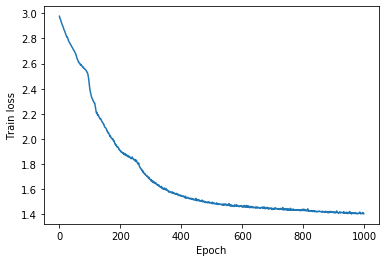

In [27]:
plt.plot(history.epoch, history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Train loss')

## Visualizing outcome

Visualizing model output:

In [28]:
# This helps with plotting X_test in ascending order!
# X_test is scrambled from train_test_split earlier
sorted_idx = np.argsort(X_test)

In [29]:
mdn_output = mdn.predict(X_test)

In [30]:
out_pi, out_mu, out_sigma = np.split(mdn_output, 3, axis=1)

In [31]:
out_pi.shape, out_mu.shape, out_sigma.shape, X_test.shape

((400, 5), (400, 5), (400, 5), (400,))

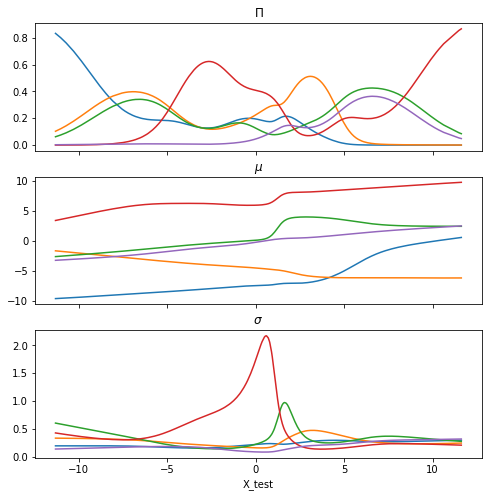

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))

for i in range(n_mixtures):
    ax1.plot(X_test[sorted_idx], out_pi[:, i][sorted_idx])
    ax2.plot(X_test[sorted_idx], out_mu[:, i][sorted_idx])
    ax3.plot(X_test[sorted_idx], out_sigma[:, i][sorted_idx])

ax1.set_title('$\Pi$')
ax2.set_title('$\mu$')
ax3.set_title('$\sigma$')
plt.xlabel('X_test')
plt.show()

Visualizing the output of each distribution on top of test data:

In [33]:
X_test.shape, out_mu.shape

((400,), (400, 5))

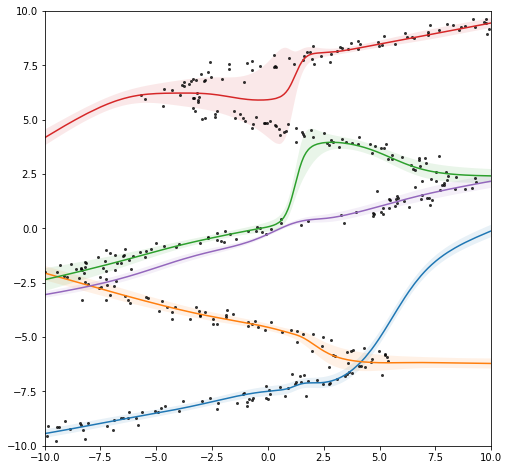

In [34]:
plt.figure(figsize=(8, 8), facecolor='white')

for i in range(n_mixtures):
    
    mu_k = out_mu[:, i][sorted_idx]
    sigma_k = out_sigma[:, i][sorted_idx]
    
    # Shade distribution as +/- sigma around mu    
    plt.plot(X_test[sorted_idx], mu_k)
    plt.fill_between(X_test[sorted_idx], mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)

plt.scatter(X_test[sorted_idx], y_test[sorted_idx], marker='.', lw=0, alpha=0.8, c='black')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

Test data are black scatters, distribution means are solid lines, and a region of +/- one standard deviation around the means are shaded. Some of the distributions managed to track the data neatly as expected for a simple toy dataset like this, though it could be better.

Now let's extract historical weights and visualize how the distributions evolved to this point.

In [35]:
weight_files = sorted(wt_path.glob('*.hdf5'))
wf_count = len(weight_files)

In [36]:
hist_mus = np.zeros(shape=(X_test.shape[0], n_mixtures, wf_count))
hist_sigmas = np.zeros(shape=(X_test.shape[0], n_mixtures, wf_count))

In [37]:
for count, i in enumerate(weight_files):
    mdn.load_weights(i)
    mdn_output = mdn.predict(X_test)
    out_pi, out_mu, out_sigma = np.split(mdn_output, 3, axis=1)
    hist_mus[:, :, count] = out_mu
    hist_sigmas[:, :, count] = out_sigma

In [38]:
hist_mus.shape, hist_sigmas.shape

((400, 5, 50), (400, 5, 50))

I prefer saving each frame one by one and stitching them with ImageMagick, as opposed to fumbling w/ matplotlib animation.

In [44]:
anim_path = Path('anim/')
if not anim_path.exists():
    anim_path.mkdir()

In [45]:
for count in range(wf_count):
    out_mu = hist_mus[:, :, count]
    out_sigma = hist_sigmas[:, :, count]
    
    plt.figure(figsize=(8, 8), facecolor='white')

    for i in range(n_mixtures):

        mu_k = out_mu[:, i][sorted_idx]
        sigma_k = out_sigma[:, i][sorted_idx]

        # Shade distribution as +/- sigma around mu    
        plt.plot(X_test[sorted_idx], mu_k)
        plt.fill_between(X_test[sorted_idx], mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)

    plt.scatter(X_test[sorted_idx], y_test[sorted_idx], marker='.', lw=0, alpha=0.8, c='black')
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    plt.title('Mixture Distributions @ Epoch %02d' % ((count + 1) * 20))
    plt.savefig('anim/%02d.png' % count)
    plt.close()

In [47]:
!convert anim/%02d.png[0-49] -delay 50 distributions_vs_epochs.gif

![distributions_vs_epochs](distributions_vs_epochs.gif)

## Using output

We will need to sample from the outputted distributions to produce usable predictions.

In [48]:
def sample_distributions(out_pi, out_mu, out_sigma, n_points):
    # Sample `n_points` from the distributions
    # for each point in the test set
    n_test = out_pi.shape[0]
    result = np.random.random(size=(n_test, n_points))
    noise = np.random.random(size=(n_test, n_points))
    
    for i in range(n_test):
        for j in range(n_points):
            idx = np.random.choice(a=range(n_mixtures), p=out_pi[i])
            result[i, j] = out_mu[i, idx] + noise[i, j] * out_sigma[i, idx]
    return result

In [49]:
y_pred = sample_distributions(out_pi, out_mu, out_sigma, 10)

In [56]:
X_test.shape, y_pred.shape, y_test.shape

((400,), (400, 10), (400,))

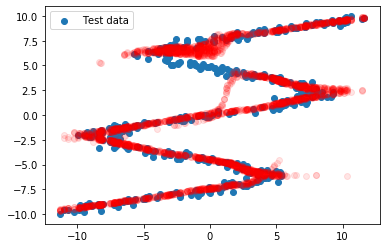

In [67]:
plt.scatter(X_test, y_test, label='Test data')
plt.legend()
plt.plot(X_test, y_pred, 'ro', alpha=0.1)
plt.show()